# Week 3 Tutorial (Solutions) - Gaussian Mixture Models

This is a fantastic topic. The distinction between Forward KL (zero-avoiding, mass-covering) and Reverse KL (zero-forcing, mode-seeking) is best understood through interaction.

Here is a structured, scaffolded notebook design. It breaks your starter code into logical educational steps: Definition, Estimation (Monte Carlo), and Optimization.

I have separated the solution code into `# TODO` blocks for the students, while keeping the plotting and infrastructure code intact so the visual feedback is immediate.

---

# Tutorial: Probability Approximations and Divergences

## 1. Introduction & Setup

In this tutorial, we will explore how to approximate a complex **Target** distribution (**P**) using a simpler **Model** distribution (**Q**). We will visualize why different divergence measures (Forward KL, Reverse KL, Jensen–Shannon) lead to different approximations.

### The Setup

- **Target (P):** A fixed Gaussian Mixture Model (GMM) with 4 components.
- **Model (Q\_θ):** A learnable GMM. We will try to learn the parameters θ (means, covariances, weights).

### 1.1 Imports and Data

First, let's define our ground truth data parameters.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as D

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- The Target Distribution P(x) ---
# We define a GMM with 4 components
means_data = torch.tensor([[0.5,0], [3,2], [-1,1], [2,-1]]) * 2
covs_data = torch.tensor([[[1,0],[0,1]], [[1,0.5],[0.5,1]], [[1,-0.5],[-0.5,1]], [[0.5,0],[0,4]]])
covs_data[1] *= 1
weights_data = torch.tensor([0.2, 0.3, 0.2, 0.3])

print("Target defined with 4 components.")

Target defined with 4 components.


## 2. The Computational Graph: Sampling and Density

To perform computations, we need two fundamental operations for our GMM:

- **Sampling:**  
  \( x \sim P(x) \)

- **Density Evaluation:**  
  \( p(x) \)

### Exercise 1: Implement GMM Density

The probability density of a GMM is the weighted sum of its component densities:

\[
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
\]

Complete the function below.

---

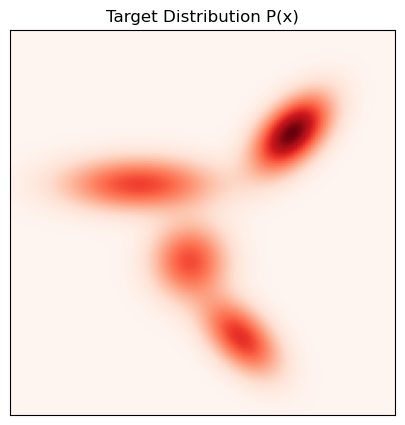

In [2]:
def gmm_sample(means, covs, weights, n):
    """
    Samples n points from a GMM.
    """
    n = int(n)
    # 1. Sample component indices according to weights (Categorical)
    indices = torch.multinomial(weights, n, replacement=True)
    
    # 2. Sample from the specific Gaussian components
    # (Here we sample from all and select, effective for batching)
    samples = torch.zeros((n, 2))
    for i in range(len(means)):
        # Create a batch of samples for this component
        # We use numpy for standard sampling here, but torch.distributions is also valid
        comp_samples = np.random.multivariate_normal(means[i].detach().numpy(), covs[i].detach().numpy(), n)
        samples[indices == i] = torch.from_numpy(comp_samples[indices == i]).float()
    return samples

def gmm_density(X, means=means_data, covs=covs_data, weights=weights_data):
    """
    Computes p(x) for a batch of points X.
    """
    # X shape: (Batch, 2)
    density = torch.zeros(X.shape[0])
    
    for i in range(len(means)):
        # TODO: Calculate the multivariate gaussian density for component i
        # Hint: You can use the formula:
        # exp(-0.5 * (x-mu)^T Sigma^-1 (x-mu)) / sqrt((2pi)^k |Sigma|)
        
        diff = X - means[i]
        # Calculate Mahalanobis distance term
        inv_cov = torch.linalg.inv(covs[i])
        exponent = -0.5 * torch.sum(diff @ inv_cov * diff, axis=1)
        
        # Calculate Normalization constant
        norm_const = torch.sqrt((2 * np.pi)**2 * torch.det(covs[i]))
        
        # Add weighted probability to total density
        prob_i = torch.exp(exponent) / norm_const
        density += weights[i] * prob_i
        
    return density

# --- Visualization Code (Do not modify) ---
def plot_density(means, covs, weights, title="Density"):
    XX, YY = torch.meshgrid(torch.linspace(-5, 10, 150), torch.linspace(-7, 8, 150), indexing='xy')
    grid_x = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)
    d = gmm_density(grid_x, means, covs, weights).reshape(150, 150)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(d.T, extent=(-5, 10, -7, 8), origin='lower', cmap='Reds')
    plt.title(title)
    plt.xlim(-5, 10); plt.ylim(-7, 8)
    plt.xticks([]); plt.yticks([])
    plt.show()

plot_density(means_data, covs_data, weights_data, "Target Distribution P(x)")

## 3. Monte Carlo Estimation

We often cannot calculate integrals like entropy

\[
H(P) = -\int p(x)\log p(x)\,dx
\]

analytically. Instead, we use Monte Carlo estimation:

\[
\mathbb{E}_{x \sim P}[f(x)] \approx \frac{1}{N}\sum_{i=1}^{N} f(x_i)
\quad \text{where } x_i \sim P(x)
\]

### Exercise 2: Estimate KL Divergence

We need to measure the distance between two distributions. The **Forward KL** is defined as:

\[
D_{\mathrm{KL}}(P \| Q) = \mathbb{E}_{x \sim P}[\log P(x) - \log Q(x)]
\]

Implement the estimator below.



In [3]:
def estimate_kl_forward(means_p, covs_p, weights_p, means_q, covs_q, weights_q, n_samples=1000):
    """
    Estimates KL(P || Q) using samples from P.
    """
    with torch.no_grad():
        # 1. Sample from P
        samples = gmm_sample(means_p, covs_p, weights_p, n_samples)
        
        # 2. Evaluate densities
        p_density = gmm_density(samples, means_p, covs_p, weights_p)
        q_density = gmm_density(samples, means_q, covs_q, weights_q)
        
        # 3. Compute Monte Carlo Estimator
        # TODO: Return the mean difference of log densities
        kl = torch.mean(torch.log(p_density) - torch.log(q_density))
        
    return kl.item()

# Test with P against itself (Should be approx 0)
print(f"KL(P||P) approx: {estimate_kl_forward(means_data, covs_data, weights_data, means_data, covs_data, weights_data):.5f}")

KL(P||P) approx: 0.00000


## 4. Optimization: Fitting the Model

Now we will define a learnable model \( Q_\theta \). We will parameterize the covariance using a factorization

\[
\Sigma = A A^{T}
\]

to ensure it remains positive semi-definite (Cholesky decomposition idea).

### Exercise 3: Forward KL (MLE)

**Objective:** Minimize

\[
D_{\mathrm{KL}}(P \| Q_\theta)
\]

\[
\mathcal{L}_{\mathrm{FKL}} = \mathbb{E}_{x \sim P}[\log P(x) - \log Q_\theta(x)]
\]

Since \( \mathbb{E}_{x \sim P}[\log P(x)] \) is constant with respect to θ, minimizing Forward KL is equivalent to **Maximizing Likelihood (MLE)**:

\[
\mathcal{L} \approx -\frac{1}{N}\sum_{i=1}^{N} \log Q_\theta(x_i)
\quad \text{where } x_i \sim P_{\text{data}}
\]

---

### Exercise 4: Reverse KL (Mode Seeking)

**Objective:** Minimize

\[
D_{\mathrm{KL}}(Q_\theta \| P)
\]

\[
\mathcal{L}_{\mathrm{RKL}} = \mathbb{E}_{x \sim Q_\theta}
[\log Q_\theta(x) - \log P(x)]
\]

Here, we sample from the model \( Q_\theta \). To backpropagate through the sampling step, we rely on the **Reparameterization Trick** (implicitly handled here by passing gradients through `means_model` in the density calculation, though strictly for GMMs, we often optimize the analytical bound or use reparameterized Gaussian sampling).

For this simple 2D case, we will use a direct Monte Carlo estimate of the integral dependent on θ.

---

--- Training with Objective: FKL ---


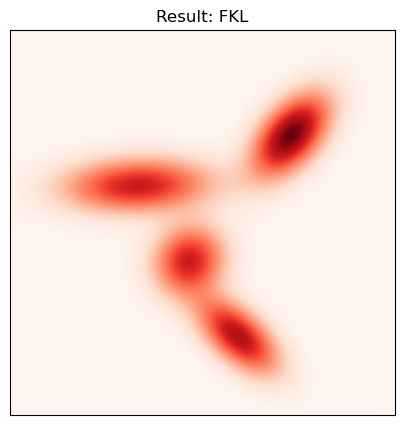

--- Training with Objective: RKL ---


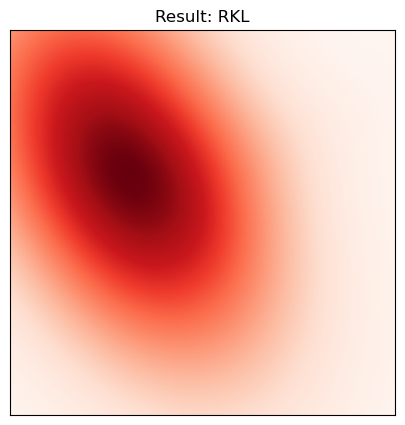

In [4]:
def train_model(objective='fkl', n_comps=4, iterations=5000):
    print(f"--- Training with Objective: {objective.upper()} ---")
    
    # --- Initialize Learnable Parameters ---
    # We use random initialization
    means_model = torch.randn((n_comps, 2), requires_grad=True)
    # We learn the square root of covariance (A) s.t. Cov = A @ A.T
    sqcovs_model = torch.stack([torch.eye(2) for _ in range(n_comps)])
    sqcovs_model.requires_grad_(True)
    # Unnormalized logits for weights
    weights_logits = torch.zeros(n_comps, requires_grad=True)

    opt = torch.optim.Adam([means_model, sqcovs_model, weights_logits], lr=0.05)
    
    loss_history = []
    
    for it in range(iterations):
        # Construct actual model parameters from learnable ones
        current_covs = sqcovs_model @ sqcovs_model.transpose(-1, -2)
        current_weights = torch.softmax(weights_logits, dim=0)
        
        # --- LOSS CALCULATION ---
        if objective == 'fkl':
            # TODO: Implement Forward KL Loss
            # 1. Sample from Target P (fixed data)
            data_samples = gmm_sample(means_data, covs_data, weights_data, 500)
            
            # 2. Evaluate Model probability on Data samples
            model_density = gmm_density(data_samples, means_model, current_covs, current_weights)
            
            # 3. Loss = Negative Log Likelihood
            loss = -torch.mean(torch.log(model_density + 1e-10))
            
        elif objective == 'rkl':
            # TODO: Implement Reverse KL Loss
            # 1. Sample from Model Q (uses reparameterization trick implicitly if we used D.Normal with rsample, 
            # but here we approximate by just evaluating log_prob at model samples)
            
            # For this tutorial, we explicitly sample using the current model params:
            # (Note: Strictly speaking, to differentiate through sampling, we need reparameterization. 
            # For GMMs this is tricky. Here we essentially perform REINFORCE or a pathwise derivative approx 
            # by evaluating log(Q) - log(P) on samples from Q.)
            
            # Generating samples from current model (detached for sampling location, 
            # but we need gradients flow through density evaluation)
            with torch.no_grad():
                model_samples = gmm_sample(means_model, current_covs, current_weights, 500)
            
            # Evaluate densities at these points
            log_q = torch.log(gmm_density(model_samples, means_model, current_covs, current_weights) + 1e-10)
            log_p = torch.log(gmm_density(model_samples, means_data, covs_data, weights_data) + 1e-10)
            
            loss = torch.mean(log_q - log_p)
            
        elif objective == 'jsd':
            # Jensen-Shannon Divergence
            # mixture M = 0.5 * (P + Q)
            # JSD = 0.5 * KL(P||M) + 0.5 * KL(Q||M)
            
            # Sample from both
            x_p = gmm_sample(means_data, covs_data, weights_data, 500)
            # x_q samples (detached)
            with torch.no_grad():
                x_q = gmm_sample(means_model, current_covs, current_weights, 500)
            
            # We estimate JSD using samples from P for the first term and Q for the second
            
            # Term 1: 0.5 * E_p [ log P - log M ]
            p_on_p = gmm_density(x_p, means_data, covs_data, weights_data)
            q_on_p = gmm_density(x_p, means_model, current_covs, current_weights)
            m_on_p = 0.5 * (p_on_p + q_on_p)
            term1 = torch.mean(torch.log(p_on_p) - torch.log(m_on_p))
            
            # Term 2: 0.5 * E_q [ log Q - log M ]
            p_on_q = gmm_density(x_q, means_data, covs_data, weights_data)
            q_on_q = gmm_density(x_q, means_model, current_covs, current_weights)
            m_on_q = 0.5 * (p_on_q + q_on_q)
            term2 = torch.mean(torch.log(q_on_q) - torch.log(m_on_q))
            
            loss = 0.5 * term1 + 0.5 * term2

        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_history.append(loss.item())

    # Final Plot
    final_covs = sqcovs_model @ sqcovs_model.transpose(-1, -2)
    final_weights = torch.softmax(weights_logits, dim=0)
    
    with torch.no_grad():
         plot_density(means_model, final_covs, final_weights, title=f"Result: {objective.upper()}")

# Run the training!
train_model('fkl') # Forward KL -> Should cover all data (mean seeking)
train_model('rkl') # Reverse KL -> Should pick one mode (mode seeking)

## 5. Discussion Questions

**Forward KL (MLE):**  
Look at the result of `fkl`. Does the model distribution cover all 4 components of the target? Why does it create *bridges* of probability density between the modes?

*Hint:* What is the penalty for \( Q(x) \approx 0 \) where \( P(x) > 0 \)?

**Reverse KL:**  
Look at the result of `rkl`. Why does it collapse to a single mode?

*Hint:* What happens if \( Q(x) \) is wide and covers areas where \( P(x) \approx 0 \)?